In [1]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../../")

In [2]:
import time
import random
import warnings
from multiprocessing import cpu_count
from itertools import chain
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import joblib
import ray

from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from src.data.processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp(stemmer=SNOWBALL_STEMMER)

corpus = []

In [4]:
# len(corpus)
clean_up.fit("Em resposta a @lucamtm da força,da fé,da febre e da fibra")

'respost forc deus febr fibr'

In [5]:
# import re
# re.sub(r"(kkk)+", " rir ", "rindo muito jkkkkkkkkkkl")

In [3]:
df = pd.read_csv(f"{os.getcwd()}/../../data/processed/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [7]:
print(random.choice(textos))
print(len(textos))

for item in list(textos[:, 0]):
    corpus.append(item)
# corpus += textos[:, 0]
# print(df[df['x'] == ''].index)
# print(df.loc[250])

['atest acab toss continu febr volt dev preocup duv' 1]
2560


In [8]:
# class Word2VecVectorizer(TransformerMixin, BaseEstimator):
    
#     def __init__(self):
#         self.w2v = Word2Vec.load(f"{os.getcwd()}/../ai/models/w2v.model")
#         # print(f"Palavras no vocab: {len(list(self.w2v.wv.vocab))}")
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         n_textos = []
#         for texto in X:
#             doc = []
#             for palavra in texto.split():
#                 try:
#                     doc.append(self.w2v.wv[palavra])
#                 except:
#                     doc.append(np.zeros(300, ))
#             n_textos.append(np.mean(doc, axis=0))
#         return StandardScaler().fit_transform(np.asarray(n_textos)) 
    
#     def fit_transform(self, X, y=None):
#         return self.transform(X)

In [9]:
# w2v = Word2VecVectorizer()
# sgd_w2v = SGDClassifier(
#     alpha=1e-7,
#     random_state=0,
#     n_jobs=-1,
#     max_iter=3000,
#     n_iter_no_change=50
# )

# pipe = make_pipeline(w2v, sgd_w2v)

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# pipe.fit(X_train, y_train)
# pred = pipe.predict(X_test)

# print(classification_report(y_test, pred))

# df_cm = confusion_matrix(pred, y_test)
# plt.figure(figsize=(6, 4))
# sn.heatmap(df_cm, annot=True, fmt="d")
# plt.tight_layout()
# plt.show()

In [10]:
validacoes, N = [], 6
for ngram_range in zip(np.ones((N), dtype=np.int), range(1, N)):
    acc, f1 = [], []
    tfidf = TfidfVectorizer(ngram_range=ngram_range, lowercase=False).fit(corpus)
    for _ in range(5):
        clf = SVC(kernel="linear", C=5, random_state=0)
        pipe = make_pipeline(tfidf, clf)

        X = textos[:, 0]
        y = textos[:, 1].astype(np.int).ravel()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)

        acc.append(round(accuracy_score(pred, y_test) * 100, 2))
        f1.append(round(f1_score(pred, y_test) * 100, 2))

    validacoes.append((
        ngram_range,
        round(np.mean(acc), 2),
        np.max(acc),
        round(np.mean(f1), 2),
        np.max(f1)
    ))

In [11]:
columns = ["NGram", "Accuracy", "Acc Max.", "F1", "F1 Max."]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1 Max.", "Acc Max.", "NGram"], ascending=False)
ngram_range = df.reset_index().loc[0]["NGram"]
df.head(25)

,NGram,Accuracy,Acc Max.,F1,F1 Max.
3,"(1, 4)",77.97,80.27,74.52,77.80
2,"(1, 3)",77.11,79.30,73.09,75.80
4,"(1, 5)",75.78,78.71,72.32,75.72
1,"(1, 2)",77.54,79.10,71.72,74.70
0,"(1, 1)",75.23,76.95,67.20,69.72


## Modelo final selecionado

In [12]:
# ngram_range = (1, 2)
print(f"NGram escolhido: {ngram_range}")
tfidf = TfidfVectorizer(ngram_range=ngram_range, lowercase=False).fit(corpus)

NGram escolhido: (1, 4)


In [13]:
# parameters = {
#     'kernel': ('linear', 'rbf'), 
#     'gamma': [0.1, 0.5, 1, 2], 
#     'C': [0.1, 0.5, 1, 5, 7, 15],
#     'random_state': [0, 10, 100, 1000]
# }

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# X = tfidf.transform(X)

# svc = SVC()
# clf = GridSearchCV(svc, parameters, cv=5, n_jobs=-1)
# clf.fit(X, y)

In [14]:
# result = []
# for param, score in zip(clf.cv_results_['params'], clf.cv_results_['split0_test_score']):
#     result.append((score, param))
# sorted(result, key=lambda x: x[0], reverse=True)

Cross Validation accuracy: 0.77 (+/- 0.02)
[0.77133106 0.77474403 0.76791809 0.77133106 0.73972603 0.77054795
 0.76712329]

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       302
           1       0.70      0.81      0.75       210

    accuracy                           0.78       512
   macro avg       0.78      0.79      0.78       512
weighted avg       0.79      0.78      0.78       512



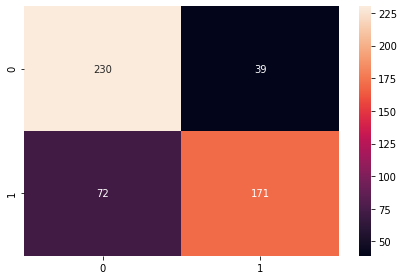

In [15]:
clf = SVC(kernel="linear", C=5, random_state=0)

pipe = make_pipeline(tfidf, clf)

X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipe.fit(X_train, y_train)

scores = cross_val_score(pipe, X_train, y_train, cv=7)
print("Cross Validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)
print()

pred = pipe.predict(X_test)
print(classification_report(y_test, pred))
df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

In [16]:
# params = {
#     'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
#     'alpha': [1e-1, 1e-3, 1e-5, 1e-7],
#     'max_iter': [500, 1000, 2000, 3000],
#     'n_iter_no_change': [10, 25, 50]
# }

# clf = make_pipeline(tfidf, 
#                     GridSearchCV(SGDClassifier(random_state=0, n_jobs=-1,),
#                                  params,
#                                  cv=5,
#                                  refit=True, n_jobs=-1))

# params = {
#     'kernel': ['linear', 'rbf', 'sigmoid'],
#     'C': [0.1, 0.5, 1, 5, 10],
#     'tol': [1e-1, 1e-2, 1e-3, 1e-4],
#     'decision_function_shape': ['ovo', 'ovr']
# }

# cv = GridSearchCV(SVC(random_state=0), params, refit=True, n_jobs=-1)
# clf = make_pipeline(tfidf, cv)

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# clf.fit(X_train, y_train)
# pred = clf.predict(X_test)

# print(classification_report(y_test, pred))

# df_cm = confusion_matrix(pred, y_test)
# plt.figure(figsize=(6, 4))
# sn.heatmap(df_cm, annot=True, fmt="d")
# plt.tight_layout()
# plt.show()

In [17]:
# clf1 = make_pipeline(w2v, sgd_w2v)
# clf2 = make_pipeline(tfidf, sgd_tfidf)

# eclf = VotingClassifier(
#     estimators=[('w2v', clf1), ('tfidf', clf2)],
#     voting='hard', weights=[1, 1], n_jobs=-1
# )

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# eclf.fit(X_train, y_train)
# pred = eclf.predict(X_test)

# print(classification_report(y_test, pred))

# df_cm = confusion_matrix(pred, y_test)
# plt.figure(figsize=(6, 4))
# sn.heatmap(df_cm, annot=True, fmt="d")
# plt.tight_layout()
# plt.show()

In [17]:
# clf = SVC(kernel="linear", C=5, random_state=0)
# pipe = make_pipeline(tfidf, clf)

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# pipe.fit(X, y)

# joblib.dump(pipe, f"{os.getcwd()}/../../ai/models/tweets_classifier.model")